# Cov-MS scoring

This notebook contains code and results for an initial exploration of machine learning-based scoring of mass spectrometry-based SARS-CoV-2 diagnostic testing. Only a very limited amount of data (70 samples) were available, and this project is still ongoing. Feedback and suggestions are welcome on https://github.com/compomics/Cov-MS-scoring/issues.

## Imports and definitions

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import numpy as np
import pandas as pd
import pickle as pkl

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_validate, LeaveOneOut, RepeatedStratifiedKFold

import covms

np.random.seed()

In [2]:
def load_cv_scores(path_to_cv_result_pkl):
    cv_result = pkl.load(open(path_to_cv_result_pkl, "rb"))
    cv_scores = pd.DataFrame({
        "PCA components": [est.best_estimator_.steps[1][1].n_components_ for est in cv_result['estimator']],
        "SVM C": [est.best_estimator_.steps[2][1].C for est in cv_result['estimator']],
        "Test": cv_result['test_score'],
        "Train": cv_result['train_score'],
    })    
    return cv_result, cv_scores

In [3]:
def label_scatter_points(x, y, val, ax=None, offset=0.2):
    if not ax:
        ax=plt.gca()
    for x, y, val in zip(x, y, val):
        ax.text(x + offset, y + offset, str(val))

In [4]:
def split_feature_importances(coef, names):
    feature_coefficients = pd.DataFrame({"Feature": names, "Coefficient": coef})

    feature_coefficients["Type"] = feature_coefficients["Feature"]\
        .apply(lambda x: ' '.join(x.split(" ")[:-1]))
    feature_coefficients["Precursor"] = feature_coefficients["Feature"]\
        .apply(lambda x: x.split(" ")[-1].split('_')[0])
    feature_coefficients["Fragment"] = feature_coefficients["Feature"]\
        .apply(lambda x: "Precursor" if not "_" in x else x.split(" ")[-1].split("_")[1] )

    data = feature_coefficients[feature_coefficients["Coefficient"] != 0].copy()
    data['Coefficient'] = data['Coefficient'].abs()
    data = data.sort_values("Coefficient", ascending=False)
    
    return data

## Loading data

70 patient samples, with both PCR and MS data are available. The MRM data was analyzed in Skyline and relevant features were exported to comma-seperated values. Code to process the Skyline export to a table with features as columns and samples as rows, can be found in `covms.py`. The processed Skyline export resulted in 433 features, of which some are on the sample level (e.g. type of swap medium, UTM or eSwab), others are on the transition level (height, width, and area of the peak, background signal, retention time deviation...) and on the precursor level (e.g. summed area for all transitions of the precursor). 

In [5]:
feature_import = covms.FeatureImport()
feature_import.from_skyline_export("data/AZDelta_output_no_recombinants.csv")
features = feature_import.features

In [6]:
target_import = covms.TargetImport(
    patient_sample_mapping=feature_import.patient_sample_mapping,
    filename="data/azdelta_pcr_results.csv"
)
target_import.read_csv()
targets = target_import.outcome

Samples `200` and `500` are recombinant peptides, not patient samples.

In [7]:
patient_exclusion_list = [200, 500]

for patient in patient_exclusion_list:
    features.drop(feature_import.patient_sample_mapping[patient], inplace=True)

Some patient samples could not be classified by PCR and were labeled inconclusive. We will exclude these:

In [8]:
features = features.loc[targets[targets != 0.5].index]
targets = targets[targets != 0.5]

Samples are available from two distinct swab types:

In [9]:
reverse_dict = lambda x: {v: k for k, v in x.items()}
swabs = pd.concat([features["Swab ID"], targets], axis=1)
swabs["Swab type"] = swabs["Swab ID"].map(reverse_dict(feature_import.swab_mapping))

swab_counts = swabs.groupby(["Swab type", "outcome"]).size().reset_index().rename(columns={0: "n"})
swab_counts

Swab type  outcome   n
0       UTM      0.0  22
1       UTM      1.0  19
2     eSwab      0.0  15
3     eSwab      1.0  14

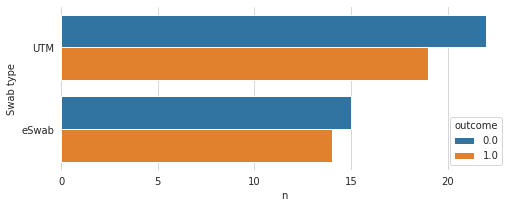

In [10]:
plt.figure(figsize=(8, 3))
sns.barplot(
    x="n", y="Swab type", hue="outcome", data=swab_counts,
    orient="h",
)
sns.despine(left=True, bottom=True)
plt.show()

41 UTM and 29 eSwab samples remain in the dataset.

## PCA + SVM

### Train and evaluate

The goal is (a) to construct a data-driven scoring function that decides whether the MRM data was generated by a sample from a COVID-19 patient or from a healthy person and (b) to evaluate which precursors and transitions generate the most meaningful diagnostic features.

Given the limited dataset size, we opted for a nested cross validation (CV) scheme in which the inner CV optimizes the hyperparameters by means of a grid search, and the outer CV evaluates the model trained on the best hyperparameters as defined by the inner CV. The inner CV uses a Leave-One-Out (LOO) approach to maximize the usage of the limited amount of data, while the outer CV uses a standard 10-fold CV. The latter allows us to repeat the procedure with different pseudorandom fold splits. The full CV scheme was repeated three times, resulting in 30 final models being trained and evaluated (3 repeats of the 10-fold CV).

To reduce the high ratio of features to the number of samples (433/70), principal component analysis (PCA) was performed before learning the ML model. For the classification task, a linear SVM algorithm was selected. These two methods, PCA and SVM, lead to two hyperparameters that require optimization in the inner CV grid search: the number of PCA components and the SVM’s C regularization term.

In [11]:
def train_and_evaluate(
    features,
    targets,
    path_to_cv_result="cv_result.pkl",
    path_to_cv_scores="cv_scores.csv"
):
    """Run cross validation scheme to train and evaluate PCA-SVM model."""
    X = features
    y = targets

    scaler = StandardScaler()
    pca = PCA()
    svm = SVC(kernel="linear", class_weight="balanced")
    pipeline = Pipeline([("scale", scaler), ("pca", pca), ("svm", svm)])

    inner_cv = LeaveOneOut()
    outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

    param_grid = dict(
        pca__n_components=range(1, min([X.shape[0] - 1, X.shape[1]]), 1),
        svm__C=[0.001, 0.01, 0.1, 1, 10, 100],
    )

    clf = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=inner_cv,
        scoring="accuracy"
    )

    cv_result = cross_validate(
        clf,
        X,
        y=y,
        cv=outer_cv,
        scoring="roc_auc",
        verbose=2,
        return_estimator=True,
        return_train_score=True,
        n_jobs=-1
    )

    pkl.dump(cv_result, open(path_to_cv_result, "wb"))
    cv_scores = pd.DataFrame({s: cv_result[s] for s in ['test_score', 'train_score']})\
        .melt(var_name='Set', value_name='AUC score')
    cv_scores.to_csv(path_to_cv_scores, index=False)

Uncomment to rerun (can take some time), or just load the saved results:

In [12]:
"""
train_and_evaluate(
    features,
    targets,
    path_to_cv_result="models/cv_result.pkl",
    path_to_cv_scores="models/cv_scores.csv"
)
"""

cv_result, cv_scores = load_cv_scores("models/cv_result.pkl")

### Model performence

Distribution of ROC-AUC scores of each of the 30 models

In [13]:
print(f"Test ROC-AUC scores on three randomized 10-fold cross validations across {len(targets)} samples")
cv_scores['Test'].describe()

Test ROC-AUC scores on three randomized 10-fold cross validations across 70 samples


count    30.000000
mean      0.836111
std       0.150801
min       0.500000
25%       0.750000
50%       0.833333
75%       1.000000
max       1.000000
Name: Test, dtype: float64

The 30 models have a mean ROC-AUC score of 0.83

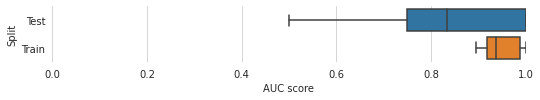

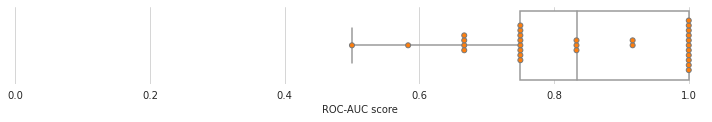

In [14]:
# Box plot
data = cv_scores.melt(id_vars=['PCA components', 'SVM C'], var_name="Split", value_name="AUC score")

sns.catplot(
    data=data, y="Split", x="AUC score",
    kind='box', orient='h', height=1.5, aspect=5
)
sns.despine(left=True, bottom=True)
plt.xlim(0,1)
plt.show()


# Box plot with individual data points overlayed
plt.figure(figsize=(10, 1.8))
sns.boxplot(cv_scores['Test'], color="#FFFFFF", width=0.9)
sns.swarmplot(cv_scores['Test'], color=sns.color_palette()[1], edgecolor="#787878", linewidth=1.0)
sns.despine(left=True, bottom=True)
plt.xlim(0)
plt.xlabel("ROC-AUC score")
plt.tight_layout()
plt.show()

Comparison of train and test scores show some overfitting on the train datasets, compared to the test datasets. The low amount of samples lead to discrete values for ROC-AUC scores.

### Which hyperparameters were selected by the inner CVs?

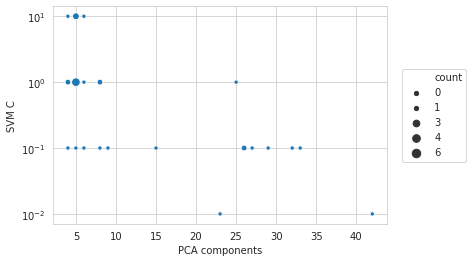

In [15]:
hyperparam_counts = cv_scores\
    .groupby(["PCA components", "SVM C"])\
    .size()\
    .rename("count")\
    .reset_index()

fig, ax = plt.subplots(1)
sns.scatterplot(
    data=hyperparam_counts,
    x='PCA components', y='SVM C', size='count', ax=ax
)
ax.set_yscale('log')
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

Mostly a (very) low number of PCA components were selected, if a higher number of PCA components was selected, mostly lower, more regulating values of C were selected for the SVM.

### Which precursors were most important to the model?

By taking the sums of each precursors features' magnitude of the values in the PCA eigenvectors, we can assess how important each precursor was during the dimensionality reduction step.

In [16]:
def get_feature_importances(cv_result):
    """Get feature importances by calculating each feature's magnitude in the PCA."""
    feature_importances = []
    # For each estimator
    for i, est in enumerate(cv_result['estimator']):
        # Get the PCA components
        components = est.best_estimator_.steps[1][1].components_
        # Calculate the magnitude for each feature
        magnitudes = pd.Series(np.linalg.norm(components, axis=0))
        feature_importances_est = split_feature_importances(magnitudes, features.columns)
        feature_importances_est['estimator'] = i
        feature_importances.append(feature_importances_est)
    feature_importances = pd.concat(feature_importances, ignore_index=True)
    return feature_importances

In [17]:
feature_importances = get_feature_importances(cv_result)

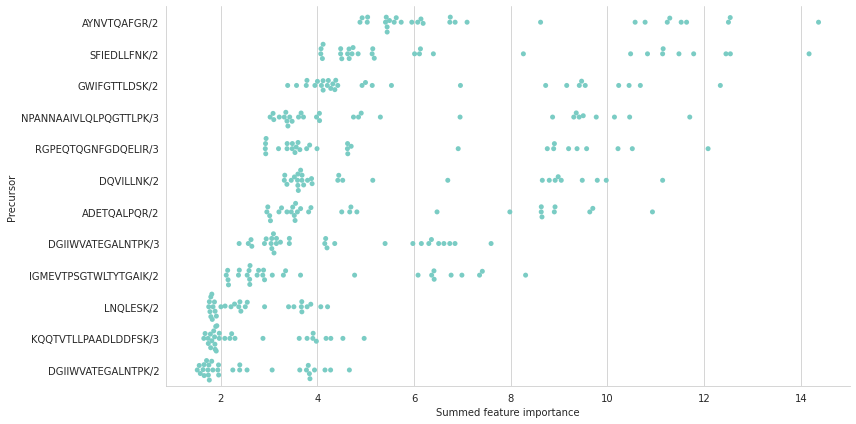

In [18]:
feature_importances_prec = feature_importances.groupby(['Precursor', 'estimator'])['Coefficient']\
    .sum()\
    .drop("ID")\
    .reset_index()\
    .rename(columns={'Coefficient': 'Summed feature importance'})

feature_importances_prec["Precursor"] = feature_importances_prec["Precursor"].astype(int)
feature_importances_prec = pd.merge(feature_import.precursor_index, feature_importances_prec, left_on='Precursor Index', right_on='Precursor')
feature_importances_prec["Precursor"] = feature_importances_prec["Peptide Modified Sequence"]\
    + "/" + feature_importances_prec["Precursor Charge"].astype(str)

feature_importances_prec["Median summed feature importance"] = feature_importances_prec["Precursor"].map(
    feature_importances_prec\
        .groupby('Precursor')["Summed feature importance"]\
        .median()
    )

feature_importances_prec.sort_values("Median summed feature importance", inplace=True, ascending=False)


num_transitions = len(feature_importances_prec['Precursor'].unique())
sns.catplot(
    data=feature_importances_prec, x='Summed feature importance', y='Precursor',
    kind='swarm', height=6, aspect=2, palette=sns.color_palette("GnBu", n_colors=1)
)
plt.show()

## PCA to two dimensions

The result of a two-dimensional can easily be plotted. To assess the impact of the swab type on the MRM results, we perform a PCA to two dimensions, without the swab type feature.

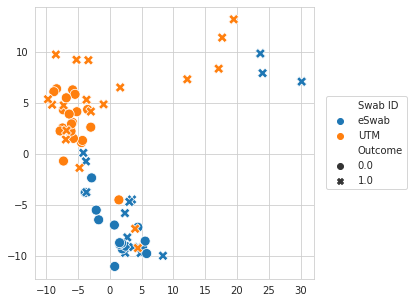

In [19]:
X = features
y = targets

# Map Swab IDs to names
def reverse(d):
    return {v: k for k, v in d.items()}

swabs = X['Swab ID'].map(reverse(feature_import.swab_mapping))

# Drop Swab ID column from features
x_drop = X.drop('Swab ID', axis=1)

# Scale the data
scaler = StandardScaler()
x_drop = scaler.fit_transform(x_drop)

# PCA
pca_drop = PCA(n_components=2)
X_drop_reduced = pca_drop.fit_transform(x_drop)

plt.figure(figsize=(5, 5))
sns.scatterplot(x=X_drop_reduced[:,0], y=X_drop_reduced[:,1], hue=swabs, style=y.rename("Outcome"), s=100)
plt.xlabel('')
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5), ncol=1)
plt.show()

There is a clear divide between UTM and eSwab samples, even more clear than the PCR outcome. For this reason, we will repeat all steps above, but train and evaluate seperate models for each swab type.

## PCA + SVM, by swab type

### Train and evaluate

In [20]:
"""
for swab_type, swab_id in feature_import.swab_mapping.items():
    features_swab = features[features["Swab ID"] == swab_id]
    targets_swab = targets.loc[features[features["Swab ID"] == swab_id].index]
    
    train_and_evaluate(
        features_swab,
        targets_swab,
        path_to_cv_result=f"models/cv_result_{swab_type}.pkl",
        path_to_cv_scores=f"models/cv_scores_{swab_type}.csv"
    )
"""

cv_result_utm, cv_scores_utm = load_cv_scores("models/cv_result_UTM.pkl")
cv_result_eswab, cv_scores_eswab = load_cv_scores("models/cv_result_eSwab.pkl")

### Model performence

Distribution of ROC-AUC scores of each of the 30 models

In [21]:
print(f"Single model mean test ROC-AUC\t: {cv_scores['Test'].mean():.3f}")
print(f"UTM mean test ROC-AUC\t\t: {cv_scores_utm['Test'].mean():.3f}")
print(f"eSwab mean test ROC-AUC\t\t: {cv_scores_eswab['Test'].mean():.3f}")

Single model mean test ROC-AUC	: 0.836
UTM mean test ROC-AUC		: 0.939
eSwab mean test ROC-AUC		: 0.650


UTM


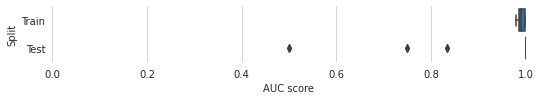

eSwab


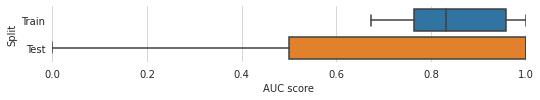

UTM


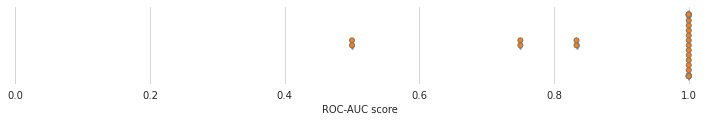

eSwab


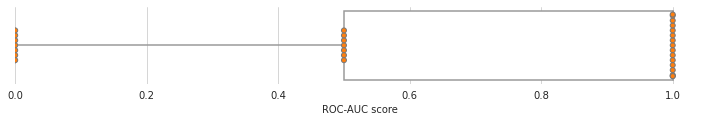

In [22]:
for cv_scores, swab_type in [(cv_scores_utm, "UTM"), (cv_scores_eswab, "eSwab")]:
    data = cv_scores.melt(id_vars=['PCA components', 'SVM C'], var_name="Split", value_name="AUC score")
    print(swab_type)
    sns.catplot(
        data=data, y="Split", x=f"AUC score", order=["Train", "Test"],
        kind='box', orient='h', height=1.5, aspect=5
    )
    sns.despine(left=True, bottom=True)
    plt.xlim(0,1)
    plt.show()

for cv_scores, swab_type in [(cv_scores_utm, "UTM"), (cv_scores_eswab, "eSwab")]:
    print(swab_type)

    plt.figure(figsize=(10, 1.8))
    sns.boxplot(cv_scores['Test'], color="#FFFFFF", width=0.9)
    sns.swarmplot(cv_scores['Test'], color=sns.color_palette()[1], edgecolor="#787878", linewidth=1.0)
    sns.despine(left=True, bottom=True)
    plt.xlim(0)
    plt.xlabel("ROC-AUC score")
    plt.tight_layout()
    plt.savefig(f"covmsscoring-linear-svm-nested-loocv-splitswab-{swab_type}.svg")
    plt.savefig(f"covmsscoring-linear-svm-nested-loocv-splitswab-{swab_type}.png")
    plt.show()

Notably, the model for UTM clearly outperforms the eSwab model, even though the UTM medium is known to generate a higher contaminating background during the MRM analysis. More investigation into these differences in performance is required.

### Hyperparameters
Which hyperparameters were selected by the 30 inner CVs?

UTM


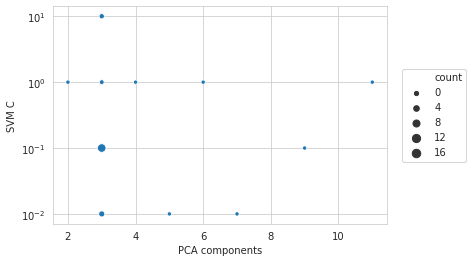

eSwab


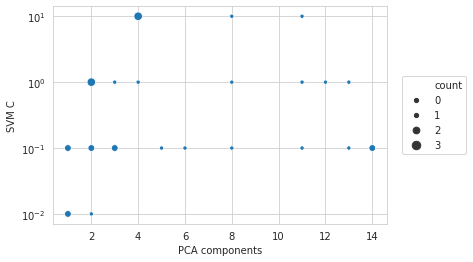

In [23]:
for cv_scores, swab_type in [(cv_scores_utm, "UTM"), (cv_scores_eswab, "eSwab")]:
    hyperparam_counts = cv_scores\
        .groupby(["PCA components", "SVM C"])\
        .size()\
        .rename("count")\
        .reset_index()

    print(swab_type)
    fig, ax = plt.subplots(1)
    sns.scatterplot(
        data=hyperparam_counts,
        x='PCA components', y='SVM C', size='count', ax=ax
    )
    ax.set_yscale('log')
    plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.show()

### Which precursors were most important to the model?

In [24]:
feature_importances_utm = get_feature_importances(cv_result_utm)
feature_importances_eswab = get_feature_importances(cv_result_eswab)

UTM


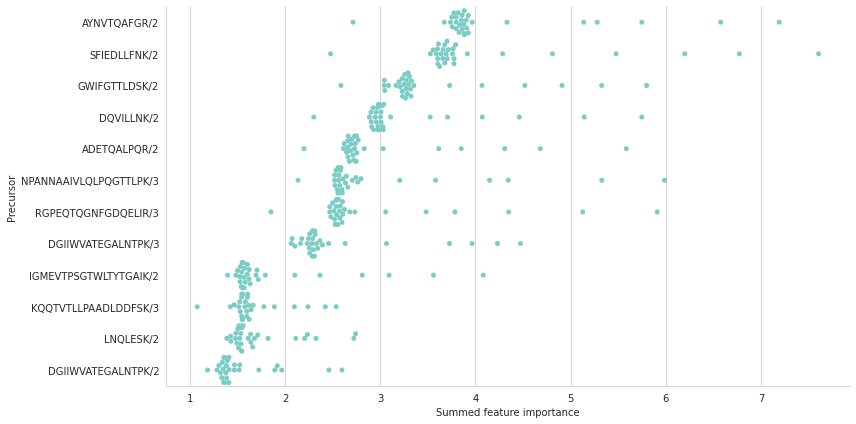

eSwab


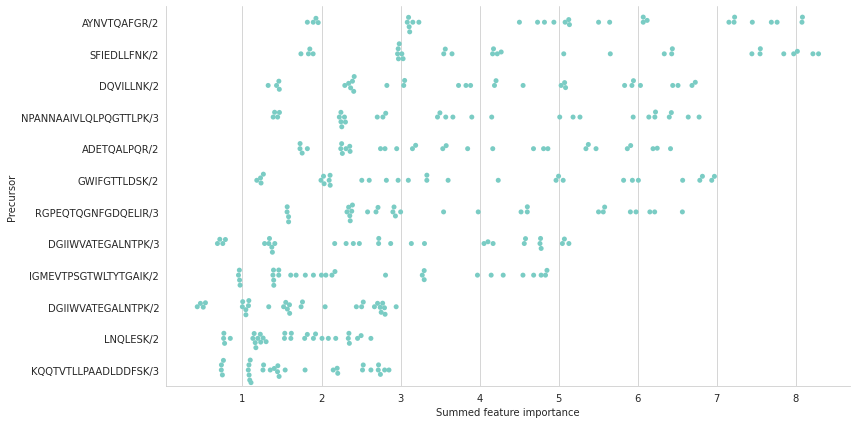

In [25]:
precursor_rank = pd.DataFrame()

for feature_importances, swab_type in [(feature_importances_utm, "UTM"), (feature_importances_eswab, "eSwab")]:
    print(swab_type)
    
    feature_importances_prec = feature_importances.groupby(['Precursor', 'estimator'])['Coefficient']\
        .sum()\
        .drop("ID")\
        .reset_index()\
        .rename(columns={'Coefficient': 'Summed feature importance'})

    feature_importances_prec["Precursor"] = feature_importances_prec["Precursor"].astype(int)
    feature_importances_prec = pd.merge(feature_import.precursor_index, feature_importances_prec, left_on='Precursor Index', right_on='Precursor')
    feature_importances_prec["Precursor"] = feature_importances_prec["Peptide Modified Sequence"]\
        + "/" + feature_importances_prec["Precursor Charge"].astype(str)

    feature_importances_prec["Median summed feature importance"] = feature_importances_prec["Precursor"].map(
        feature_importances_prec\
            .groupby('Precursor')["Summed feature importance"]\
            .median()
        )

    feature_importances_prec.sort_values("Median summed feature importance", inplace=True, ascending=False)


    num_transitions = len(feature_importances_prec['Precursor'].unique())
    sns.catplot(
        data=feature_importances_prec, x='Summed feature importance', y='Precursor',
        kind='swarm', height=6, aspect=2, palette=sns.color_palette("GnBu", n_colors=1)
    )
    plt.show()
    
    # Add medians and ranks to df
    precursor_rank[swab_type + " median"] = feature_importances_prec\
        .groupby('Precursor')["Summed feature importance"]\
        .median()\
    
    precursor_rank[swab_type + " rank"] = feature_importances_prec\
        .groupby('Precursor')["Summed feature importance"]\
        .median()\
        .rank(ascending=False)

We can compare the feature importances by precursor between swab types:

Median summed feature importance


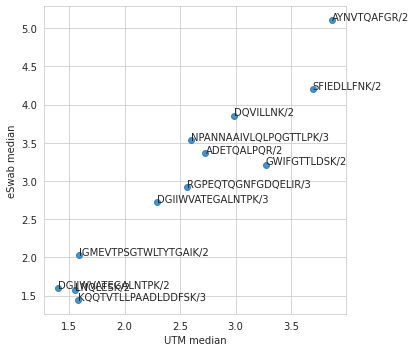

Ranked feature importance


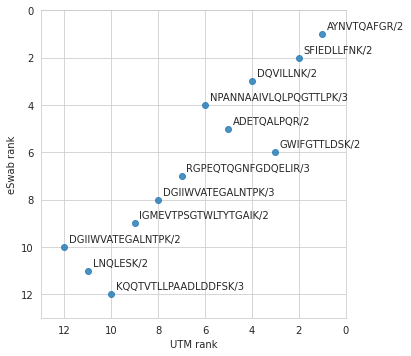

In [26]:
# Plot median summed importance
print("Median summed feature importance")
sns.lmplot(data=precursor_rank, x="UTM median", y="eSwab median", fit_reg=False)
label_scatter_points(precursor_rank["UTM median"], precursor_rank["eSwab median"], precursor_rank.index, offset=0.0001)
sns.despine(left=False, right=False, top=False, bottom=False)
plt.show()

# Plot ranks
print("Ranked feature importance")
sns.lmplot(data=precursor_rank, x="UTM rank", y="eSwab rank", fit_reg=False)
label_scatter_points(precursor_rank["UTM rank"], precursor_rank["eSwab rank"], precursor_rank.index, offset=-0.2) 
plt.gca().set_xlim(len(precursor_rank)+1, 0)
plt.gca().set_ylim(len(precursor_rank)+1, 0)
sns.despine(left=False, right=False, top=False, bottom=False)
plt.show()

Even though the performance of the UTM and eSwab models differ drastically, the same precursors show to generate the most distcriminative features. 

## PCA to three components, SVM, plot the decision plane

Because most inner CVs selected a low number of PCA components, we can replicate this and plot the reduced feature space in 3D, with the SVM decision hyperplane superimposed on the data.

In [27]:
def plot_svc_3d(clf, X, Y):
    z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]

    tmp = np.linspace(-5,5,30)
    x,y = np.meshgrid(tmp,tmp)

    fig = plt.figure()
    ax  = fig.add_subplot(111, projection='3d')
    ax.plot3D(X[Y==0,0], X[Y==0,1], X[Y==0,2],'ob')
    ax.plot3D(X[Y==1,0], X[Y==1,1], X[Y==1,2],'sr')
    ax.plot_surface(x, y, z(x,y))
    ax.view_init(30, 60)
    plt.show()

In [28]:
def get_svc_plane_coordinates(clf):
    z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]
    tmp = np.linspace(-5,5,30)
    x,y = np.meshgrid(tmp,tmp)
    return x, y, z(x, y)

#### UTM

In [29]:
scaler = StandardScaler()
pca = PCA(n_components=3)
svc = SVC(kernel="linear", class_weight="balanced", C=1)

X = features[features["Swab ID"] == 0]
Y = targets.loc[features[features["Swab ID"] == 0].index]

X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)
svc.fit(X_pca, Y)

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

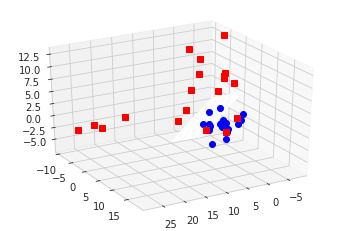

In [30]:
plot_svc_3d(svc, X_pca, Y)

We can also make this plot interactive:

In [31]:
import plotly.express as px
import plotly.graph_objects as go

pca_result = pd.DataFrame(X_pca, columns=["PC 1", "PC 2", "PC 3"])
pca_result["outcome"] = Y.astype(str).values

fig = px.scatter_3d(
    pca_result, x='PC 1', y='PC 2', z='PC 3',
    color='outcome'
)
x, y, z = get_svc_plane_coordinates(svc)
fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.7, surfacecolor=np.zeros(shape=x.shape), showscale=False))

fig.show()

#### eSwab

In [32]:
scaler = StandardScaler()
pca = PCA(n_components=3)
svc = SVC(kernel="linear", class_weight="balanced", C=1)

X = features[features["Swab ID"] == 1]
Y = targets.loc[features[features["Swab ID"] == 1].index]

X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)
svc.fit(X_pca, Y)

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

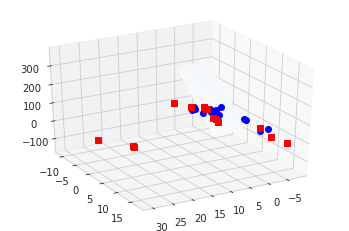

In [33]:
plot_svc_3d(svc, X_pca, Y)

We can also make this plot interactive:

In [34]:
import plotly.express as px
import plotly.graph_objects as go

pca_result = pd.DataFrame(X_pca, columns=["PC 1", "PC 2", "PC 3"])
pca_result["outcome"] = Y.astype(str).values

fig = px.scatter_3d(
    pca_result, x='PC 1', y='PC 2', z='PC 3',
    color='outcome'
)
x, y, z = get_svc_plane_coordinates(svc)
fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.7, surfacecolor=np.zeros(shape=x.shape), showscale=False))

fig.show()

For eSwab, there is not as clear a seperation as with UTM.